# Solving the Data Center Cooling problem
## Deep Q Learning
![](https://s-media-cache-ak0.pinimg.com/originals/36/d1/87/36d18741bdd4d2ac0033c53bcc669148.jpg)

##### Summary
1. Theory behind Deep-Q-Learning
2. Implementation

##### Libraries

In [2]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
sys.path.append("c:/git/reinforcement-learning/")


# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Seaborn config
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

# Deep Learning (Keras, Tensorflow)
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D,ZeroPadding2D,Conv2D
from keras.utils.np_utils import to_categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
# Theory behind Deep-Q-Learning

***
# Environment

In [3]:
from rl.env.data_center_cooling import DataCenterCooling

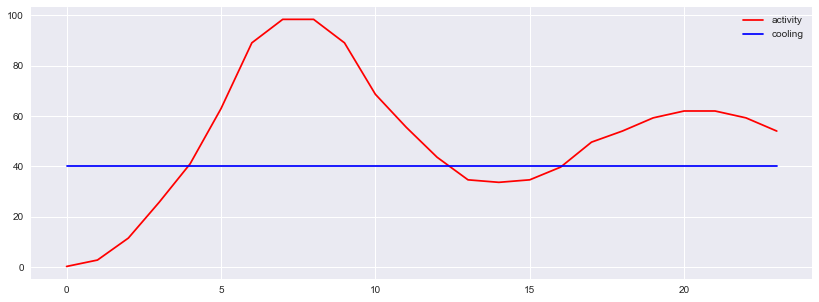

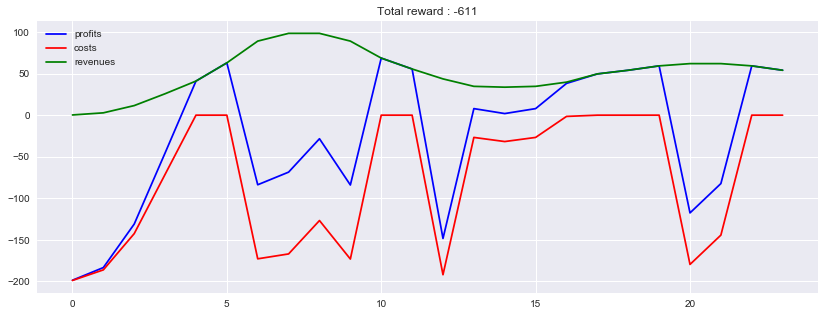

In [4]:
env = DataCenterCooling(levels_cooling=10)
env.render()

# Deep-Q-Learning
- Do a feedforward pass for the current state s to get predicted Q-values for all actions.
- Do a feedforward pass for the next state s’ and calculate maximum overall network outputs max a’ Q(s’, a’).
- Set Q-value target for action to r + γmax a’ Q(s’, a’) (use the max calculated in step 2). For all other actions, set the Q-value target to the same as originally returned from step 1, making the error 0 for those outputs.
- Update the weights using backpropagation.

##### Initialize model

In [106]:
def initialize_Q_model(states,actions):
    model = Sequential()
    model.add(Dense(32,input_dim = states))
    model.add(Activation("relu"))
    model.add(Dense(actions))
    model.add(Activation("linear"))

    model.compile(loss='mse',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [107]:
model = initialize_Q_model(len(env.observation_space),len(env.action_space))

In [124]:
def run_episode_deep(env,model,memory = None,max_step = 100,episode_number = 0,lr = 0.8,gamma = 0.95,verbose = 1,epsilon = 0.5):
    s = env.reset()
    
    episode_reward = 0
    
    i = 0
    while i < max_step:
        
        # Convert the state to a state vector
        s_vector = to_categorical(s,len(env.observation_space))
        
        # Choose an action with a decayed epsilon greedy exploration
        epsilon_decayed = epsilon/(episode_number/10 + 1)
        q = model.predict(s_vector)
        if np.random.rand() > epsilon:
            a = np.argmax(q)
        else:
            a = np.random.randint(len(env.action_space))
            
        
        # Take the action, and get the reward from environment
        s_new,r,done = env.step(a)
        
        # Convert the new state to a state vector
        s_new_vector = to_categorical(s_new,len(env.observation_space))
        q_new = model.predict(s_new_vector)
        
        
        if verbose: print("{} -> {} : ".format(s,s_new),"reward ",r," action ",a,"!!!" if done else "")
        
        # Update our knowledge in the Q-table
        X = s_vector
        y = q
        
        if not done:
            y[0][a] = r + gamma * np.max(q_new)
        else:
            y[0][a] = r
            
        
        
        # Caching to train later
        if memory is not None:
            memory.cache(X,y)
            
            
        
        
        
        # Update the caches
        episode_reward += r
        s = s_new
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return model,episode_reward,env

In [5]:
from rl.memory import Memory
memory = Memory()

In [126]:
run_episode_deep(env,m,memory = memory)

0 -> 1 :  reward  -46.0919104214  action  1 
1 -> 2 :  reward  -12.3838310028  action  1 
2 -> 3 :  reward  -151.244226512  action  1 
3 -> 15 :  reward  -76.8204527323  action  6 
15 -> 18 :  reward  41.2052612692  action  7 
18 -> 19 :  reward  93.7613500103  action  9 
19 -> 19 :  reward  104.91011381  action  6 
19 -> 18 :  reward  -7.43695110166  action  6 
18 -> 16 :  reward  -71.1554964869  action  0 
16 -> 11 :  reward  -71.7090711741  action  3 
11 -> 7 :  reward  57.0236867028  action  4 
7 -> 4 :  reward  -35.0223026181  action  6 
4 -> 3 :  reward  -126.296758169  action  7 
3 -> 6 :  reward  -119.50378597  action  1 
6 -> 8 :  reward  -120.401854535  action  2 
8 -> 10 :  reward  40.5167887619  action  5 
10 -> 13 :  reward  36.4735177168  action  6 
13 -> 15 :  reward  62.076601622  action  6 
15 -> 14 :  reward  -50.1952396627  action  2 
14 -> 13 :  reward  -59.0854937642  action  9 
13 -> 10 :  reward  62.076601622  action  6 
10 -> 8 :  reward  -13.5264822832  action 

(<keras.models.Sequential at 0x13c091d0>,
 -383.0495003298513,
 <ai.rl.cooling_center.CoolingCenter at 0xde9fb00>)

In [127]:
def run_n_episodes_deep(env,n_episodes = 2000,lr = 0.8,gamma = 0.95,epsilon = 0.8,batch_size = 32):
    
    # Initialize the Q-table
    model = initialize_Q_model(len(env.observation_space),len(env.action_space))
    memory = Memory()
    
    # Store the rewards
    rewards = []
    
    # Experience replay
    for i in tqdm(range(n_episodes)):
        
        # Run the episode
        model,episode_reward,env_temp = run_episode_deep(env,model,memory = memory,episode_number=i,lr = lr,gamma = gamma,verbose = 0,epsilon = epsilon)
        rewards.append(episode_reward)
        
        # Training
        inputs,targets = memory.sample(batch_size)
        model.train_on_batch(inputs,targets)
        
    
    # Plot rewards
    average_running_rewards = np.cumsum(rewards)/np.array(range(1,len(rewards)+1))
    plt.figure(figsize = (15,4))
    plt.plot(average_running_rewards)
    plt.show()
        
    return model,rewards
        

100%|██████████████████████████████████████| 5000/5000 [17:53<00:00,  2.34it/s]


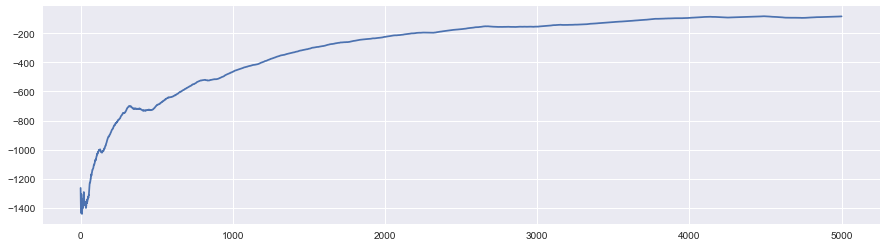

In [141]:
m,r = run_n_episodes_deep(env,5000,epsilon=0.2)

https://www.quora.com/What-is-difference-between-DQN-and-Policy-Gradient-methods

Policy gradient methods, and more generally policy-based methods find the optimal policy by directly optimizing for the long term reward.
By contrast, policy networks take a simpler approach. Simply input the state and out comes an action! Then you simply find out which actions worked well and increase their probability. This may sound exceedingly stupid, and it is, but this approach cracked AlphaGo! ;)

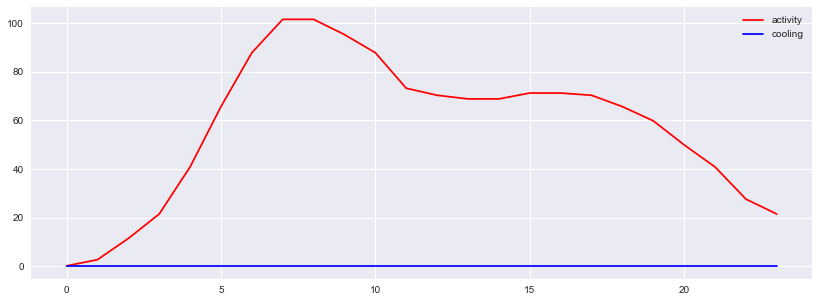

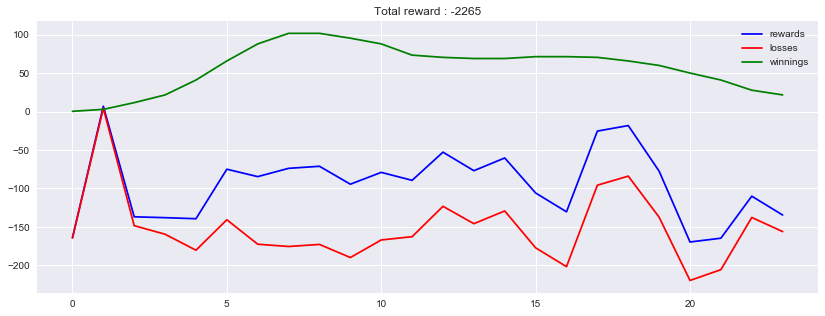

In [142]:
env.reset()
env.render()

In [143]:
model_temp,r,env = run_episode_deep(env,m,episode_number=200,verbose = True)

0 -> 1 :  reward  -448.562299774  action  9 
1 -> 2 :  reward  -433.322549581  action  9 
2 -> 3 :  reward  -142.290302372  action  1 
3 -> 7 :  reward  -45.468401465  action  4 
7 -> 15 :  reward  -68.8451645747  action  0 
15 -> 18 :  reward  62.9002066994  action  6 
18 -> 19 :  reward  84.3607946229  action  9 
19 -> 19 :  reward  -88.4693424371  action  2 
19 -> 18 :  reward  98.3852621793  action  7 
18 -> 16 :  reward  84.3607946229  action  9 
16 -> 11 :  reward  68.6260232333  action  6 
11 -> 8 :  reward  -16.8709646358  action  7 
8 -> 5 :  reward  -167.150415155  action  0 
5 -> 4 :  reward  7.86429383117  action  4 
4 -> 5 :  reward  1.90538614756  action  4 
5 -> 6 :  reward  7.86429383117  action  4 
6 -> 9 :  reward  -211.822863432  action  9 
9 -> 10 :  reward  -152.306172761  action  9 
10 -> 13 :  reward  24.0895181023  action  6 
13 -> 14 :  reward  55.5879041788  action  6 
14 -> 14 :  reward  -46.6551496326  action  4 
14 -> 13 :  reward  -78.0771717131  action  9

In [144]:
env.cooling

array([[90, 90, 10, 40,  0, 60, 90, 20, 70, 90, 60, 70,  0, 40, 40, 40, 90,
        90, 60, 60, 40, 90, 40, 50]])

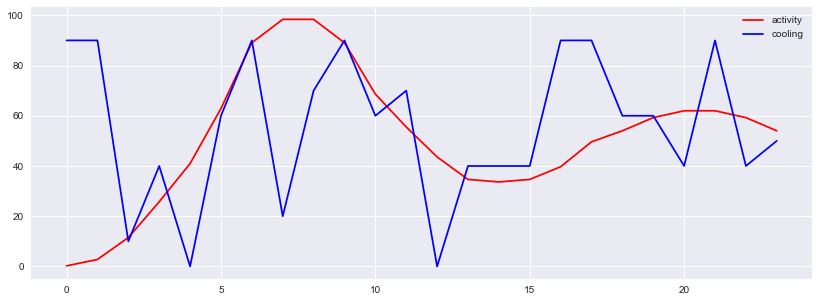

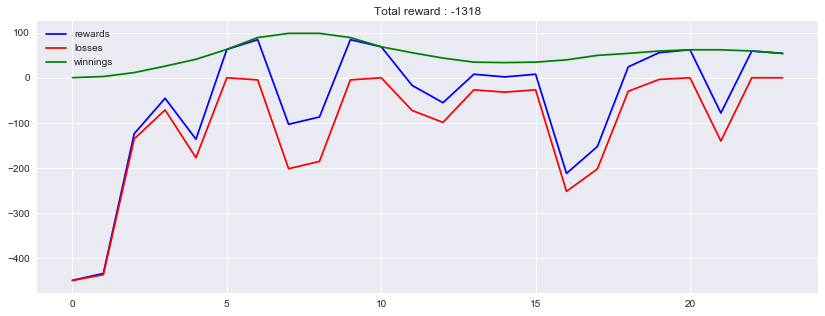

In [146]:
env.render()